In [1]:
import sys
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output

sys.path.append("../src")

from kitti_io.loader import SequenceLoader
from kitti_io.calibration import KittiCalibration
from detection.stereo_sift_scene_flow import StereoSIFT, StereoSceneFlowDetector
from tracking.kalman import MultiObjectTracker
from detection.yolov8_detector import YoloV8Detector
from detection.optical_flow import OpticalFlowDetector
from detection.sparse_motion import SparseMotionDetector
from visualization.bbox_utils import draw_bounding_boxes



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/envs/pfas/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/pfas/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/pfas/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/pfas/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
 

In [2]:
# Path to your data sequence (change as needed)
SEQ_PATH = "../data_rect/seq_01"

# Visualization settings
SHOW_RIGHT_CAMERA = False
DISPLAY_SCALE = 0.8        # resize for display
DRAW_FLOW = True          # draw tracked points
DRAW_MOVING_POINTS = True # draw points classified as moving
SAVE_OUTPUT = False        # save frame-by-frame images
OUTPUT_DIR = "output_seq01"

if SAVE_OUTPUT:
    os.makedirs(OUTPUT_DIR, exist_ok=True)


In [3]:
# Load sequence
loader = SequenceLoader(SEQ_PATH, return_gray=False)
print(f"Loaded {len(loader)} frames from sequence {SEQ_PATH}")

# Initialize optical flow detector
detector = OpticalFlowDetector(
    motion_threshold=1.3,
    dbscan_eps=18,
    dbscan_min_samples=5,
    min_box_area=100
)

print("Detector initialized")


Loaded 145 frames from sequence ../data_rect/seq_01
Detector initialized


In [4]:
def show_frame(frame, boxes=None, moving_pts=None, flow_pts=None, figsize=(10,6)):
    """
    Visualize frame, bounding boxes, and optional debugging info.
    Uses matplotlib to avoid OpenCV window issues in Jupyter.
    """
    img = frame.copy()

    # Draw bounding boxes
    if boxes:
        for (x1, y1, x2, y2) in boxes:
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)

    # Draw motion points (foreground)
    if DRAW_MOVING_POINTS and moving_pts is not None:
        for (x, y) in moving_pts:
            cv2.circle(img, (int(x), int(y)), 2, (0,0,255), -1)

    # Draw tracked points (all)
    if DRAW_FLOW and flow_pts is not None:
        for (x, y) in flow_pts:
            cv2.circle(img, (int(x), int(y)), 2, (255,0,0), -1)

    # RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=figsize)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()


Frame 144, Detections: 2


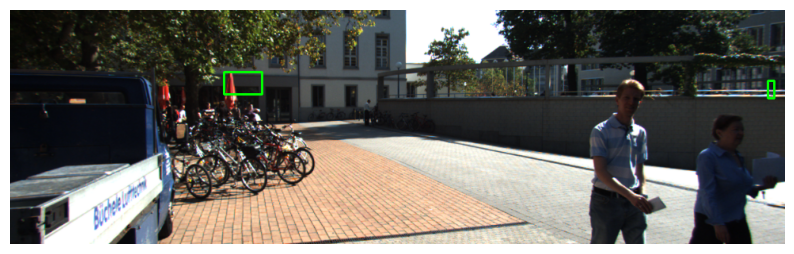

Testing complete.


In [5]:
N = len(loader)  # how many frames to test, or set to len(loader)

all_detections = []

for idx, frame_info in enumerate(loader):
    if idx >= N:
        break

    frame_left = frame_info["left"]
    frame_right = frame_info["right"] if SHOW_RIGHT_CAMERA else None

    boxes = detector.detect(frame_left)
    all_detections.append((idx, boxes))

    # Prepare visualization
    vis_frame = cv2.resize(
        frame_left,
        (0,0),
        fx=DISPLAY_SCALE,
        fy=DISPLAY_SCALE
    )

    # Visualization helpers from detector
    moving_pts = getattr(detector, "debug_moving_pts", None)
    flow_pts = getattr(detector, "prev_points", None)

    clear_output(wait=True)
    print(f"Frame {idx}, Detections: {len(boxes)}")
    show_frame(vis_frame, boxes=boxes)

    # Save output frames (optional)
    if SAVE_OUTPUT:
        out_path = os.path.join(OUTPUT_DIR, f"frame_{idx:06d}.png")
        cv2.imwrite(out_path, vis_frame)
print("Testing complete.")

In [6]:
# Count non-empty detections
non_empty = sum(1 for f, b in all_detections if len(b) > 0)
print(f"Detections found in {non_empty}/{len(all_detections)} frames")

# Print first few detections
for i in range(10):
    print(all_detections[i])


Detections found in 83/145 frames
(0, [])
(1, [[313, 134, 591, 370], [272, 345, 295, 369]])
(2, [[327, 142, 586, 368], [739, 130, 761, 137], [438, 211, 454, 222]])
(3, [[369, 121, 618, 372], [443, 211, 462, 227], [381, 289, 414, 308]])
(4, [[369, 146, 641, 373]])
(5, [[369, 144, 648, 377]])
(6, [[398, 138, 645, 379], [248, 156, 258, 177]])
(7, [[399, 139, 654, 379], [241, 156, 253, 179], [449, 244, 468, 283], [728, 129, 742, 137]])
(8, [[440, 135, 677, 373], [221, 156, 268, 215], [464, 239, 485, 285], [246, 286, 288, 320], [725, 129, 739, 137]])
(9, [[455, 136, 694, 377], [351, 154, 363, 167], [251, 214, 288, 292], [243, 150, 265, 186], [281, 305, 302, 312], [719, 129, 736, 137]])


In [17]:
if SAVE_OUTPUT:
    print("Rendering video...")

    out_video = cv2.VideoWriter(
        "output_seq01.mp4",
        cv2.VideoWriter_fourcc(*"mp4v"),
        10,
        (vis_frame.shape[1], vis_frame.shape[0])
    )

    for idx in range(len(all_detections)):
        boxes = all_detections[idx][1]
        frame_info = loader.get_frame(idx)
        frame = cv2.resize(frame_info["left"], (vis_frame.shape[1], vis_frame.shape[0]))

        for (x1, y1, x2, y2) in boxes:
            cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0),2)
        
        out_video.write(frame)

    out_video.release()
    print("Video saved → output_seq01.mp4")


## Sparse motion detector (notebook port)


In [ ]:
sparse_loader = SequenceLoader(SEQ_PATH, return_gray=False)
sparse_detector = SparseMotionDetector()
print(f"Sparse detector will process {len(sparse_loader)} frames")


In [ ]:
SPARSE_N = len(sparse_loader)  # iterate through entire sequence by default
sparse_detections = []

for idx, frame_info in enumerate(sparse_loader):
    if idx >= SPARSE_N:
        break

    frame_left = frame_info["left"]
    boxes = sparse_detector.detect(frame_left)
    sparse_detections.append((idx, boxes))

    vis = cv2.resize(frame_left, (0, 0), fx=DISPLAY_SCALE, fy=DISPLAY_SCALE)
    vis = draw_bounding_boxes(vis, boxes, color=(0, 200, 0))

    clear_output(wait=True)
    print(f"[Sparse detector] Frame {idx}, boxes: {len(boxes)}")
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

print("Sparse detection complete")


In [ ]:
non_empty_sparse = sum(1 for _, boxes in sparse_detections if boxes)
print(f"Sparse detector found motion in {non_empty_sparse}/{len(sparse_detections)} frames")
print("First few results:")
for idx, boxes in sparse_detections[:5]:
    print(idx, boxes)


try yolo detector

In [18]:
SEQ_PATH = "../data_rect/seq_01"

loader = SequenceLoader(SEQ_PATH, return_gray=False)
detector = YoloV8Detector(
    model_path="yolov8n.pt",  # or "yolov8s.pt" etc.
    device="cuda",            # or "cpu" if no GPU
    conf_threshold=0.3,
    restrict_to_kitti_types=True,
)

print(f"Frames in sequence: {len(loader)}")

Frames in sequence: 145


In [19]:
def show_frame_with_dets(frame, dets, scale=0.8):
    vis = cv2.resize(frame, (0,0), fx=scale, fy=scale)
    for d in dets:
        x1, y1, x2, y2 = d["bbox"]
        cls = d["kitti_type"] or d["class_name"]
        cv2.rectangle(vis, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(vis, cls, (x1, max(0, y1-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.imshow(vis_rgb)
    plt.axis("off")
    plt.show()


In [20]:
for i, frame_info in enumerate(loader):
    if i >= 50:
        break

    frame = frame_info["left"]
    dets = detector.detect(frame)

    clear_output(wait=True)
    print(f"Frame {i}, detections: {len(dets)}")
    show_frame_with_dets(frame, dets)


Ultralytics 8.3.229 🚀 Python-3.10.18 torch-2.2.2 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: None
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


test stero sift detector

In [7]:
calib_file = "../data_rect/calib_cam_to_cam.txt"   # adjust as needed
calib = KittiCalibration(calib_file)

print("Loaded calibration:")
calib.print_info()

Loaded calibration:
K2 (left intrinsics):
 [[     956.95           0      693.98]
 [          0      952.24      238.61]
 [          0           0           1]]
K3 (right intrinsics):
 [[      901.1           0      698.29]
 [          0      897.06      237.74]
 [          0           0           1]]
P2 (P_rect_02):
 [[     707.05           0      604.08      45.758]
 [          0      707.05      180.51    -0.34542]
 [          0           0           1    0.004981]]
P3 (P_rect_03):
 [[     707.05           0      604.08     -334.11]
 [          0      707.05      180.51      2.3307]
 [          0           0           1   0.0032012]]
T2: [   0.059897  -0.0013678   0.0046376]
T3: [   -0.47563   0.0052966  -0.0054372]
Baseline: 0.5355238800000001


In [9]:
SEQ_PATH = "../data_rect/seq_01" 

# Load stereo sequence
loader = SequenceLoader(SEQ_PATH, return_gray=False)
print("Frames in sequence:", len(loader))

# Init stereo SIFT + scene flow detector
stereo_sift = StereoSIFT(K_left=calib.K2, P_left=calib.P2, P_right=calib.P3)
detector = StereoSceneFlowDetector(
    stereo_sift,
    motion_threshold=0.25,   # 25 cm motion threshold in 3D
    dbscan_eps=18,
    dbscan_min_samples=5,
    min_box_area=120
)

print("Stereo Scene Flow Detector initialized.")


Frames in sequence: 145
Stereo Scene Flow Detector initialized.


In [10]:
def show_frame(frame, boxes, moving_pts=None, all_matches=None, scale=0.75):
    vis = cv2.resize(frame, (0,0), fx=scale, fy=scale)
    
    # draw boxes
    for (x1, y1, x2, y2) in boxes:
        x1 = int(x1 * scale)
        x2 = int(x2 * scale)
        y1 = int(y1 * scale)
        y2 = int(y2 * scale)
        cv2.rectangle(vis, (x1,y1), (x2,y2), (0,255,0), 2)

    # draw all matched points (yellow)
    if all_matches is not None:
        for (x,y) in all_matches:
            cv2.circle(vis, (int(x*scale), int(y*scale)), 2, (0,255,255), -1)

    # draw moving points (red)
    if moving_pts is not None:
        for (x,y) in moving_pts:
            cv2.circle(vis, (int(x*scale), int(y*scale)), 3, (0,0,255), -1)

    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


Frame 144  |  Detected boxes: 0


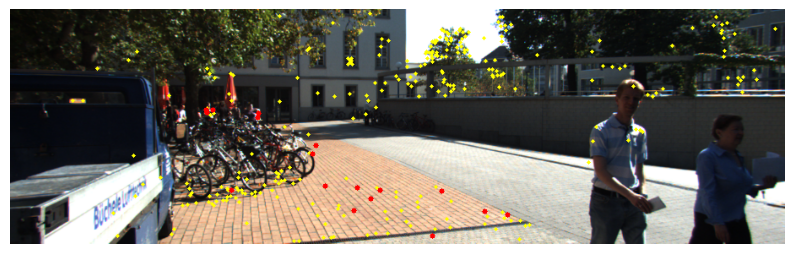

In [11]:
N = len(loader)   # number of frames to test
for i, frame in enumerate(loader):
    if i >= N:
        break
    
    left = frame["left"]
    right = frame["right"]

    boxes = detector.detect(left, right)

    # Debug points from detector (3D motion masked → 2D positions)
    moving = detector.debug_moving_points_2d
    all_matches = detector.debug_all_matches_2d

    clear_output(wait=True)
    print(f"Frame {i}  |  Detected boxes: {len(boxes)}")

    show_frame(left, boxes, moving_pts=moving, all_matches=all_matches)


In [12]:
if detector.debug_moving_points_2d is not None:
    print("Moving points:", len(detector.debug_moving_points_2d))


Moving points: 19


with Kalman

In [13]:
# Paths
SEQ_PATH = "../data_rect/seq_01"
CALIB_PATH = "../data_rect/calib_cam_to_cam.txt"

# Load calibration
calib = KittiCalibration(CALIB_PATH)
calib.print_info()

# Initialize loader
loader = SequenceLoader(SEQ_PATH, return_gray=False)
print("Frames in sequence:", len(loader))

# Initialize stereo SIFT + scene flow detector
stereo_sift = StereoSIFT(calib.K2, calib.P2, calib.P3)
detector = StereoSceneFlowDetector(
    stereo_sift,
    motion_threshold=0.25,
    dbscan_eps=18,
    dbscan_min_samples=5,
    min_box_area=120
)

# Initialize multi-object tracker (Kalman)
tracker = MultiObjectTracker(
    max_age=10,
    min_hits=3,
    iou_threshold=0.3
)


K2 (left intrinsics):
 [[     956.95           0      693.98]
 [          0      952.24      238.61]
 [          0           0           1]]
K3 (right intrinsics):
 [[      901.1           0      698.29]
 [          0      897.06      237.74]
 [          0           0           1]]
P2 (P_rect_02):
 [[     707.05           0      604.08      45.758]
 [          0      707.05      180.51    -0.34542]
 [          0           0           1    0.004981]]
P3 (P_rect_03):
 [[     707.05           0      604.08     -334.11]
 [          0      707.05      180.51      2.3307]
 [          0           0           1   0.0032012]]
T2: [   0.059897  -0.0013678   0.0046376]
T3: [   -0.47563   0.0052966  -0.0054372]
Baseline: 0.5355238800000001
Frames in sequence: 145


In [14]:
def show_frame_with_tracks(frame, tracks, scale=0.8):
    vis = cv2.resize(frame, (0,0), fx=scale, fy=scale)

    for t in tracks:
        x1, y1, x2, y2 = t["bbox"]
        tid = t["id"]
        x1s, y1s = int(x1*scale), int(y1*scale)
        x2s, y2s = int(x2*scale), int(y2*scale)
        cv2.rectangle(vis, (x1s, y1s), (x2s, y2s), (0,255,0), 2)
        cv2.putText(vis, f"ID {tid}", (x1s, max(0,y1s-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.imshow(vis_rgb)
    plt.axis("off")
    plt.show()


Frame 144 | detections: 0 | active tracks: 1


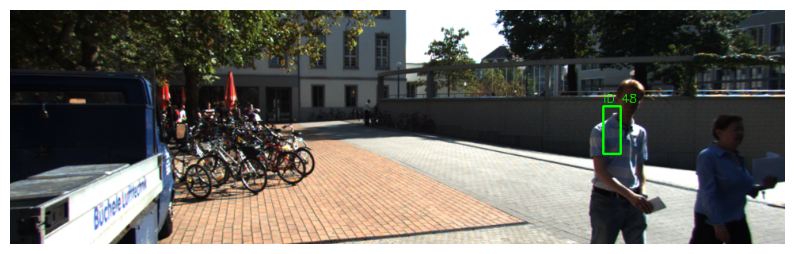

In [15]:
N_FRAMES = 200  # how many frames to process
all_tracks_per_frame = []  # for saving later

for idx, frame_info in enumerate(loader):
    if idx >= N_FRAMES:
        break

    left = frame_info["left"]
    right = frame_info["right"]

    # 1) Detection from stereo SIFT scene flow
    boxes = detector.detect(left, right)  # list of [x1,y1,x2,y2]

    # 2) Update Kalman-based tracker
    tracks = tracker.update(boxes)

    # Save for later (classification/export)
    all_tracks_per_frame.append({
        "frame": idx,
        "tracks": tracks,
    })

    clear_output(wait=True)
    print(f"Frame {idx} | detections: {len(boxes)} | active tracks: {len(tracks)}")

    # 3) Visualize
    show_frame_with_tracks(left, tracks, scale=0.8)


In [ ]:
SAVE_DIR = "../crops_seq01"
os.makedirs(SAVE_DIR, exist_ok=True)

for item in all_tracks_per_frame:
    frame_idx = item["frame"]
    # You might want to reload frame here if you didn't keep it;
    # assuming we reload via loader:
    frame_info = loader.get_frame(frame_idx)
    img = frame_info["left"]

    for t in item["tracks"]:
        tid = t["id"]
        x1, y1, x2, y2 = map(int, t["bbox"])
        crop = img[max(0,y1):max(0,y2), max(0,x1):max(0,x2)]

        if crop.size == 0:
            continue

        out_name = f"frame_{frame_idx:06d}_id_{tid}.png"
        cv2.imwrite(os.path.join(SAVE_DIR, out_name), crop)
